In [1]:
from helpers.benchmark import load_records_from_directory
import pandas as pd
from helpers.benchmark import filter_cpu_data

def build_region_filtered_df(
    df: pd.DataFrame,
    configs: list[tuple[str, int]],
    benchmarks: list[str],
    group_on_timestamp: bool = False,
    remove_cold: bool = True,
) -> pd.DataFrame:
    """
    Build a single DF where filtering/outlier removal is applied *per region*:
      - subset provider/memory/benchmark
      - iterate regions present in that subset
      - call filter_cpu_data(..., region=r) -> Tukey done within that region
      - concat all regions back together
    """
    parts = []

    for provider, memory_size in configs:
        for bench in benchmarks:
            base = df[
                (df["provider"] == provider)
                & (df["memory_size_mb"] == memory_size)
                & (df["benchmark_type"] == bench)
            ]

            if base.empty:
                continue

            regions = sorted(base["region"].dropna().unique().tolist())
            for r in regions:
                part = filter_cpu_data(
                    df=base,                    # <-- use prefiltered base
                    provider=provider,
                    memory_size=memory_size,
                    benchmark=bench,
                    group_on_timestamp=group_on_timestamp,
                    region=r,
                    remove_cold=remove_cold,
                    no_outlier_filter=False
                )
                if not part.empty:
                    parts.append(part)

    if not parts:
        return df.iloc[0:0].copy()

    out = pd.concat(parts, ignore_index=True)

    # Optional: ensure timestamp dtype (usually already ok from parse_log_file)
    if "timestamp" in out.columns:
        out["timestamp"] = pd.to_datetime(out["timestamp"], utc=True)

    return out




LOG_DIR = "data/stage_a"
df_raw = load_records_from_directory(LOG_DIR)
print("loaded records:", len(df_raw))

STAGE_A_CONFIGS = [("aws", 512), ("alibaba", 512), ("gcp", 512), ("azure", 512)]
BENCHMARKS = ["gemm"]  # add more if you want, e.g. ["gemm","gzip","sha256"]

df = build_region_filtered_df(df_raw, STAGE_A_CONFIGS, BENCHMARKS)

print("raw rows:", len(df_raw))
print("region-clean rows:", len(df))

# billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/alibaba")
# df = inject_billed_alibaba(df, billed_alibaba_df)

# billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/azure")
# df = inject_billed_azure(df, billed_azure_df)

# billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/gcp")
# df = inject_billed_gcp(df, billed_gcp_df)

# billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/aws")
# df = inject_billed_aws(df, billed_aws_df)



loaded records: 324863
raw rows: 324863
region-clean rows: 66588


Saved: plots/stage_a/aws_512MB_regional_lollipop.pdf


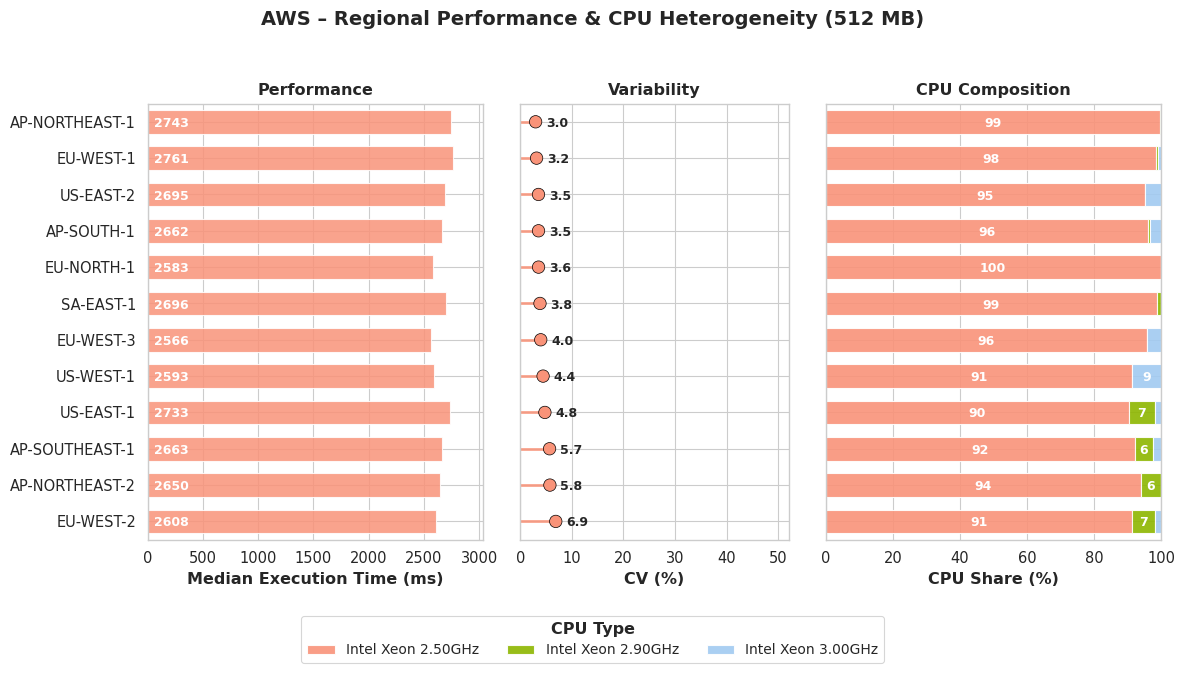

Saved: plots/stage_a/alibaba_512MB_regional_lollipop.pdf


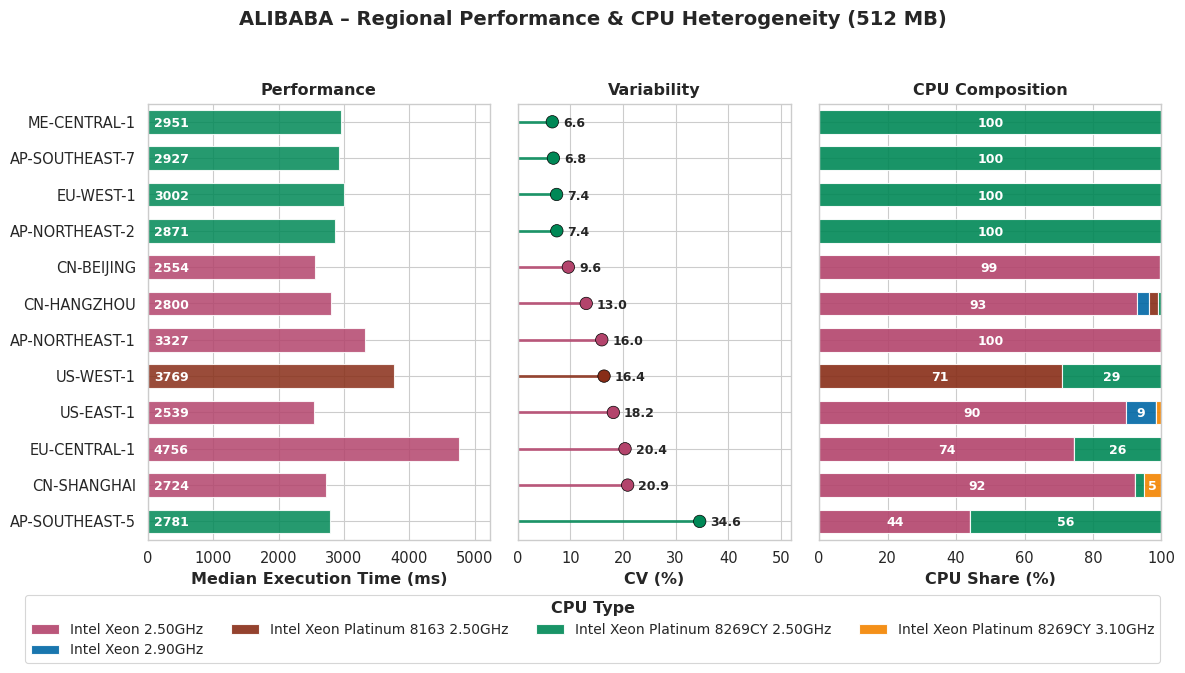

Saved: plots/stage_a/gcp_512MB_regional_lollipop.pdf


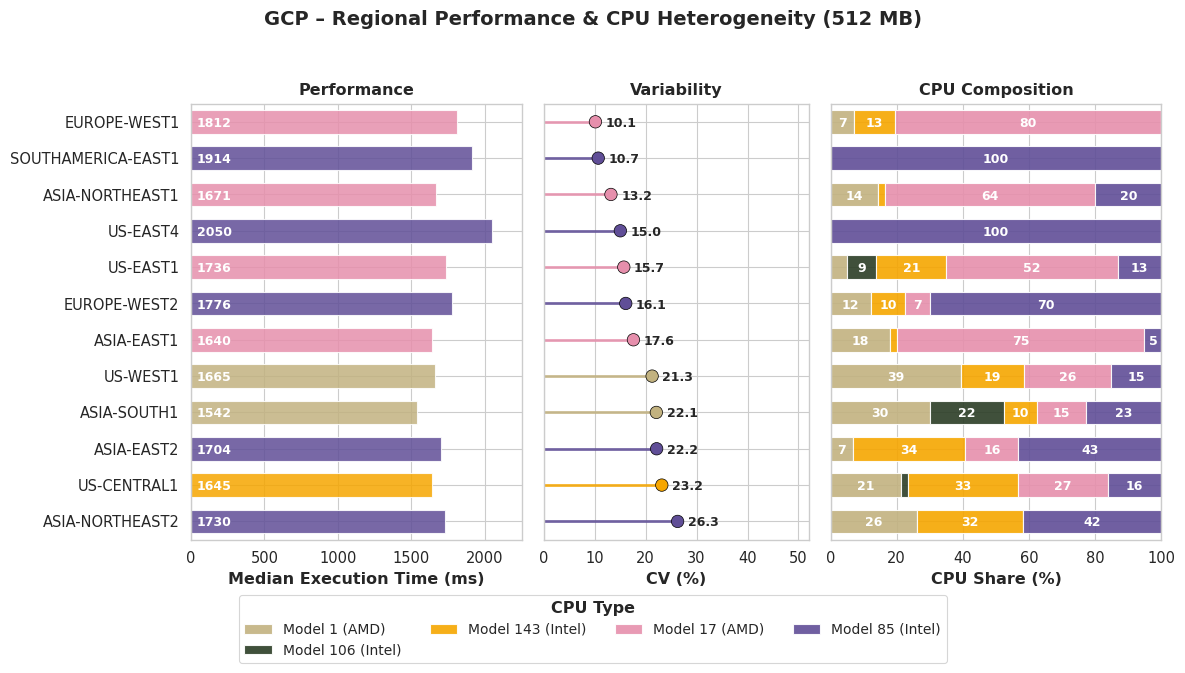

Saved: plots/stage_a/azure_512MB_regional_lollipop.pdf


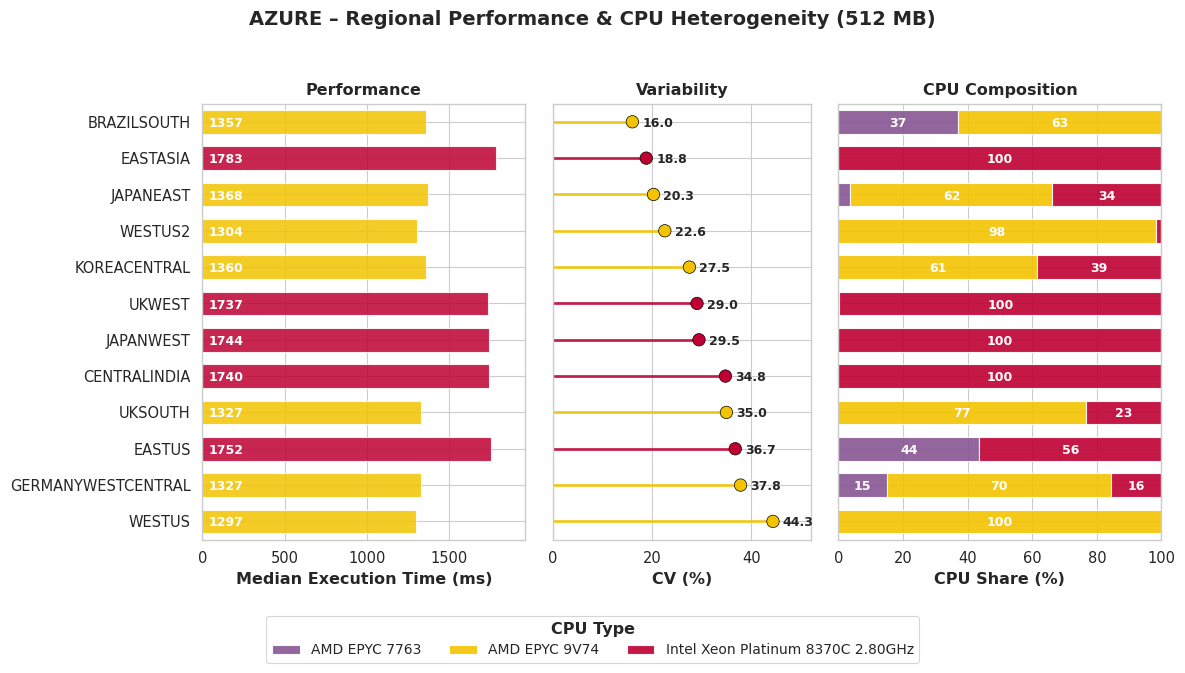

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def create_regional_performance_lollipop(
    df: pd.DataFrame,
    provider: str,
    memory_size: int = 512,
    benchmark_type: str = "gemm",
    sort_by: str = "cv",  # "perf" or "cv"
    out_dir: str = "plots/stage_a",
    show: bool = True,
):
    """
    Three-panel figure: Performance (median) | Variability (CV) | CPU Composition
    """
    # --- Filter data ---
    df_base = df[
        (df["provider"] == provider)
        & (df["memory_size_mb"] == memory_size)
        & (df["benchmark_type"] == benchmark_type)
    ].copy()

    metric = metric_for_benchmark(benchmark_type)
    df_base = df_base.dropna(subset=[metric, "region", "cpu_type", "instance_id"])
    
    if df_base.empty:
        print(f"No data for {provider} {memory_size}MB {benchmark_type}")
        return

    # --- Per-instance mean, then regional stats ---
    df_inst = (
        df_base.groupby(["region", "instance_id", "cpu_type"], as_index=False)[metric]
        .mean()
        .rename(columns={metric: "inst_mean"})
    )

    regional_stats = df_inst.groupby("region")["inst_mean"].agg(
        median="median",
        mean="mean", 
        std="std",
    )
    regional_stats["cv"] = regional_stats["std"] / regional_stats["mean"] * 100

    # --- Sort regions ---
    if sort_by == "cv":
        regions_sorted = regional_stats.sort_values("cv", ascending=False).index.tolist()
    else:
        regions_sorted = regional_stats.sort_values("median", ascending=False).index.tolist()
    
    regional_stats = regional_stats.reindex(regions_sorted)

    # --- CPU composition ---
    cpu_dist = df_base.groupby(["region", "cpu_type"]).size().unstack(fill_value=0)
    cpu_dist = cpu_dist.div(cpu_dist.sum(axis=1), axis=0) * 100
    cpu_dist = cpu_dist.reindex(regions_sorted)

    # Dominant CPU per region (for bar colors)
    dominant_cpu = cpu_dist.idxmax(axis=1).to_dict()

    # --- Colors ---
    all_cpu_types = sorted(df_base["cpu_type"].unique())
    cpu_colors = get_cpu_palette(all_cpu_types, provider=provider)
    bar_colors = [cpu_colors.get(dominant_cpu.get(r, "Unknown"), "#7f8c8d") for r in regions_sorted]

    # --- Plot ---
    n_regions = len(regions_sorted)
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3,
        figsize=(12, max(6, n_regions * 0.55)),
        gridspec_kw={"width_ratios": [1, 0.8, 1]},
    )
    y_pos = np.arange(n_regions)
    bar_height = 0.65

    # LEFT: Median performance
    median_vals = regional_stats["median"].values
    ax1.barh(y_pos, median_vals, color=bar_colors, alpha=0.85, height=bar_height)
    for i, val in enumerate(median_vals):
        ax1.text(
            median_vals.max() * 0.02, 
            y_pos[i],  # Use y_pos directly, not bar geometry
            f"{val:.0f}", 
            ha="left", 
            va="center_baseline",  # This centers on y_pos[i]
            color="white", 
            fontweight="bold", 
            fontsize=9
        )
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([r.upper() for r in regions_sorted])
    ax1.set_xlabel("Median Execution Time (ms)", fontweight="bold")
    ax1.set_title("Performance", fontweight="bold")
    ax1.set_xlim(0, median_vals.max() * 1.1)

    # MIDDLE: CV lollipop
    cv_vals = regional_stats["cv"].values
    for i, val in enumerate(cv_vals):
        ax2.hlines(y=y_pos[i], xmin=0, xmax=val, color=bar_colors[i], linewidth=2, alpha=0.85)
    ax2.scatter(cv_vals, y_pos, color=bar_colors, s=80, zorder=5, edgecolor="black", linewidth=0.5)
    for i, val in enumerate(cv_vals):
        ax2.text(
            val + 2, 
            y_pos[i], 
            f"{val:.1f}", 
            ha="left", 
            va="center_baseline", 
            fontweight="bold",
            fontsize=9
        )
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel("CV (%)", fontweight="bold")
    ax2.set_title("Variability", fontweight="bold")
    ax2.set_xlim(0, 52)

    # RIGHT: CPU composition stacked bars
    left = np.zeros(n_regions)
    for cpu_type in all_cpu_types:
        if cpu_type not in cpu_dist.columns:
            continue
        vals = cpu_dist[cpu_type].values
        ax3.barh(y_pos, vals, left=left, label=shorten_cpu_name(cpu_type),
                 color=cpu_colors.get(cpu_type, "#7f8c8d"), alpha=0.9, edgecolor="white", height=bar_height)
        for i, v in enumerate(vals):
            if v > 5:
                ax3.text(
                    left[i] + v / 2, 
                    y_pos[i] ,  # Use y_pos directly
                    f"{v:.00f}", 
                    ha="center", 
                    va="center_baseline", 
                    fontweight="bold", 
                    fontsize=9, 
                    color="white"
                )
        left += vals

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([])
    ax3.set_xlabel("CPU Share (%)", fontweight="bold")
    ax3.set_title("CPU Composition", fontweight="bold")
    ax3.set_xlim(0, 100)

    # Shared y-limits
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(-0.5, n_regions - 0.5)

    # Legend & title
    handles, labels = ax3.get_legend_handles_labels()
    leg = fig.legend(handles, labels, title="CPU Type", loc="lower center", bbox_to_anchor=(0.5, -0.02), ncol=min(4, len(handles)), fontsize=10)
    leg.get_title().set_fontweight("bold")

    fig.suptitle(f"{provider.upper()} – Regional Performance & CPU Heterogeneity ({memory_size} MB)", fontsize=14, fontweight="bold", y=0.98)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    # Save
    os.makedirs(out_dir, exist_ok=True)
    filename = f"{out_dir}/{provider}_{memory_size}MB_regional_lollipop.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=150)
    print(f"Saved: {filename}")

    if show:
        plt.show()
    else:
        plt.close(fig)


# --- Usage ---
for provider in ["aws", "alibaba", "gcp", "azure"]:
    create_regional_performance_lollipop(df, provider=provider, memory_size=512, sort_by="cv")

Saved: plots/stage_a/cpu_consistency_ecdf_raw_sns.pdf


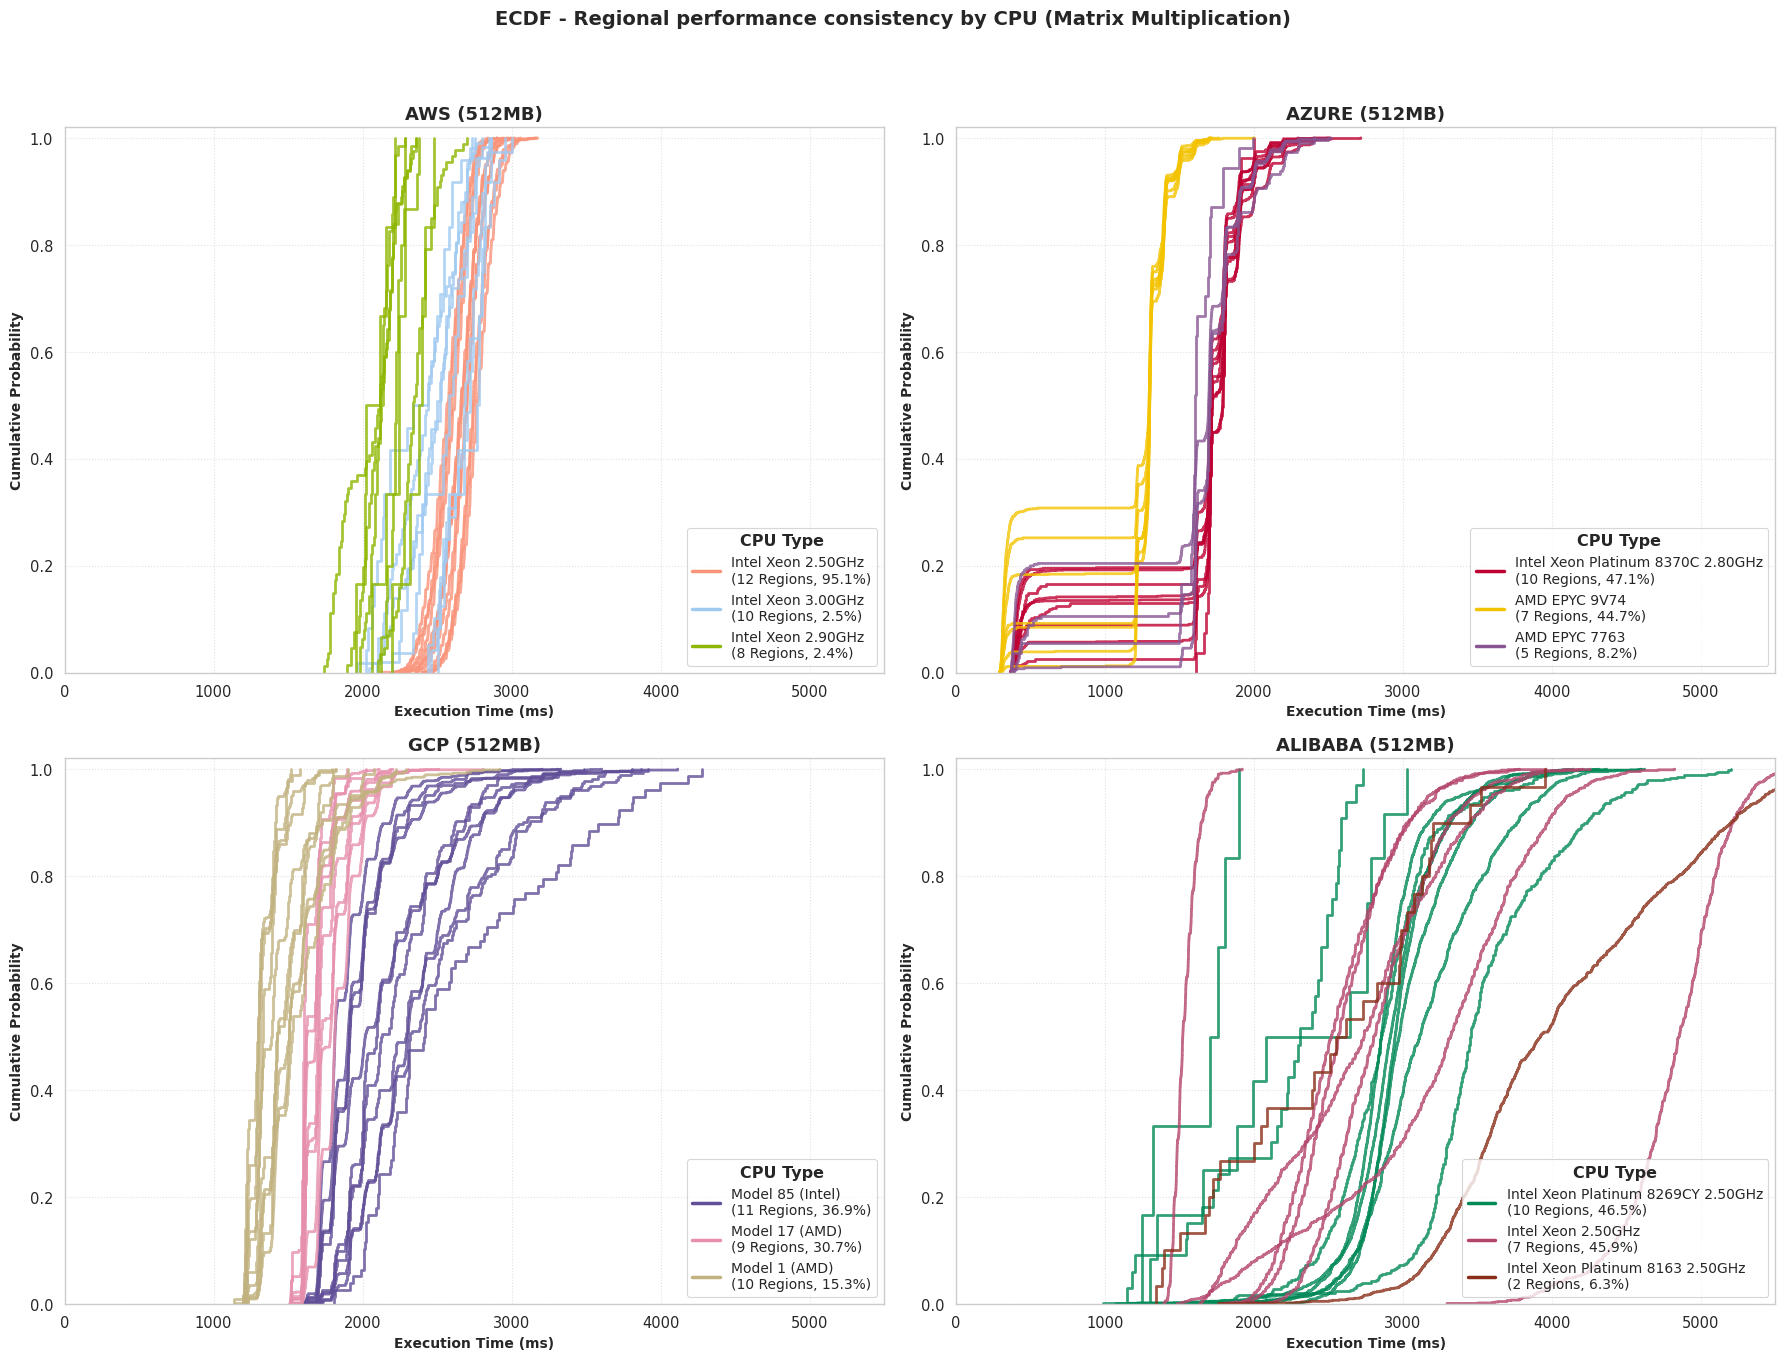

In [8]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def select_top_cpus_raw(df_prov: pd.DataFrame, top_n: int = 3, min_instances: int = 20) -> list[str]:
    """
    Select top CPUs by number of unique instances (stable), using raw (warm) rows.
    """
    if df_prov.empty:
        return []

    cpu_stats = (
        df_prov.groupby("cpu_type")["instance_id"]
        .nunique()
        .rename("n_instances")
        .to_frame()
    )
    cpu_stats = cpu_stats[cpu_stats["n_instances"] >= min_instances]

    return (
        cpu_stats.sort_values("n_instances", ascending=False)
        .head(top_n)
        .index
        .tolist()
    )


def plot_cpu_consistency_ecdf_raw(
    df: pd.DataFrame,
    providers: list[str] | None = None,
    memory_configs: dict[str, int] | None = None,
    benchmark_type: str = "gemm",
    top_n: int = 3,
    min_instances: int = 20,
    out_dir: str = "../holy/plots/StageA",
    show: bool = True,
):
    """
    ECDF plots using sns.ecdfplot: each line is one CPU type in one region.
    """

    if providers is None:
        providers = ["aws", "azure", "gcp", "alibaba"]
    if memory_configs is None:
        memory_configs = {p: 512 for p in providers}

    metric = metric_for_benchmark(benchmark_type)

    n = len(providers)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 7 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        memory_size = memory_configs.get(provider, 512)

        df_prov = df[
            (df["provider"] == provider)
            & (df["memory_size_mb"] == memory_size)
            & (df["benchmark_type"] == benchmark_type)
        ].copy()

        if df_prov.empty or metric not in df_prov.columns:
            ax.text(0.5, 0.5, f"No Data: {provider.upper()}", ha="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        df_prov = df_prov.dropna(subset=["cpu_type", "region", "instance_id", metric])
        if df_prov.empty:
            ax.text(0.5, 0.5, f"No Valid Rows: {provider.upper()}", ha="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        top_cpus = select_top_cpus_raw(df_prov, top_n=top_n, min_instances=min_instances)
        if not top_cpus:
            ax.text(0.5, 0.5, "Insufficient CPU Samples", ha="center", transform=ax.transAxes)
            ax.axis("off")
            continue

        # consistent CPU colors
        cpu_colors = get_cpu_palette(top_cpus, provider=provider)

        # axis limits
        xmax = df_prov.loc[df_prov["cpu_type"].isin(top_cpus), metric].max()
        ax.set_xlim(0, xmax * 1.05 if pd.notna(xmax) and xmax > 0 else None)
        ax.set_ylim(0, 1.02)

        total_instances = df_prov["instance_id"].nunique()
        legend_elements = []

        for cpu_name in top_cpus:
            cpu_data = df_prov[df_prov["cpu_type"] == cpu_name]
            regions = sorted(cpu_data["region"].dropna().unique())

            cpu_instances = cpu_data["instance_id"].nunique()
            share = (cpu_instances / total_instances * 100.0) if total_instances else 0.0

            cpu_clean = shorten_cpu_name(cpu_name)
            color = cpu_colors.get(cpu_name, "#7f8c8d")

            # Plot each region as separate ECDF line (same color)
            for region in regions:
                region_data = cpu_data[cpu_data["region"] == region]
                if len(region_data) < 5:
                    continue

                sns.ecdfplot(
                    data=region_data,
                    x=metric,
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    ax=ax,
                    legend=False
                )

            # Add to custom legend
            legend_elements.append(
                Line2D([0], [0], color=color, linewidth=2.5,
                       label=f"{cpu_clean}\n({len(regions)} Regions, {share:.1f}%)")
            )

        if legend_elements:
            leg = ax.legend(
                handles=legend_elements,
                title="CPU Type",
                fontsize=10,
                loc="lower right",
            )
            leg.get_title().set_fontweight("bold")

        ax.set_xlim(0, 5500)
        ax.set_title(f"{provider.upper()} ({memory_size}MB)", fontweight="bold", fontsize=13)
        ax.set_xlabel("Execution Time (ms)", fontweight="bold", fontsize=10)
        ax.set_ylabel("Cumulative Probability", fontweight="bold", fontsize=10)
        ax.grid(True, linestyle=":", alpha=0.6)
      

    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        "ECDF - Regional performance consistency by CPU (Matrix Multiplication)",
        fontsize=14,
        fontweight="bold",
        y=0.99,
    )
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])

    os.makedirs(out_dir, exist_ok=True)
    out_file = f"{out_dir}/cpu_consistency_ecdf_raw_sns.pdf"
    plt.savefig(out_file, bbox_inches="tight")
    print(f"Saved: {out_file}")

    if show:
        plt.show()
    else:
        plt.close(fig)


# Example usage
mixed_memory_config = {"aws": 512, "gcp": 512, "alibaba": 512, "azure": 512}

plot_cpu_consistency_ecdf_raw(
    df,
    providers=["aws", "azure", "gcp", "alibaba"],
    memory_configs=mixed_memory_config,
    benchmark_type="gemm",
    top_n=3,
    min_instances=5,
    out_dir="plots/stage_a",
)

AWS instance-level median per region (where both CPUs appear):


cpu_type,region,Intel Xeon 2.90GHz,Intel Xeon 3.00GHz,improvement_% (3.00 vs 2.50),speed_ratio (3.00/2.50)
0,ap-northeast-2,2129.827540,2301.681943,-8.068935,1.080689
4,eu-west-2,2141.219480,2387.247975,-11.490111,1.114901
3,eu-west-1,2366.367784,2713.136546,-14.654052,1.146541
5,us-east-1,2354.100220,2705.444687,-14.924788,1.149248
2,ap-southeast-1,2119.186765,2560.414846,-20.820632,1.208206
1,ap-south-1,2082.991818,2687.690678,-29.030304,1.290303


/tmp/ipykernel_8089/307723972.py:78: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


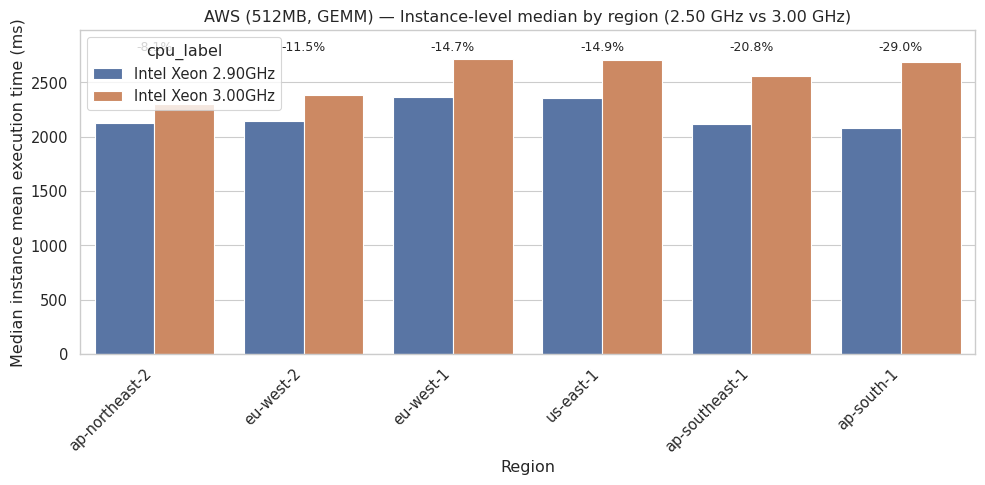

In [13]:
# --- AWS: region-wise instance-level median comparison + DELTA IN % (2.50 vs 3.00) ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name

metric = metric_for_benchmark("gemm")

df_aws = df[
    (df["provider"] == "aws") &
    (df["memory_size_mb"] == 512) &
    (df["benchmark_type"] == "gemm")
].copy()

df_aws_inst = to_instance_means(df_aws, metric=metric, min_warm=3)

cpu_25 = "Intel Xeon 2.90 GHz"
cpu_30 = "Intel Xeon 3.00 GHz"

available = set(df_aws_inst["cpu_type"].dropna().unique().tolist())
if cpu_25 not in available:
    cand = [c for c in available if ("2.90" in c and "Xeon" in c)]
    if cand:
        cpu_25 = sorted(cand)[0]
if cpu_30 not in available:
    cand = [c for c in available if ("3.00" in c and "Xeon" in c)]
    if cand:
        cpu_30 = sorted(cand)[0]

df_pair = df_aws_inst[df_aws_inst["cpu_type"].isin([cpu_25, cpu_30])].copy()

# Regions where BOTH CPU types appear
regions_both = (
    df_pair.groupby("region")["cpu_type"]
    .nunique()
    .loc[lambda s: s >= 2]
    .index
    .tolist()
)
df_pair = df_pair[df_pair["region"].isin(regions_both)].copy()

if df_pair.empty:
    print("No regions found where BOTH CPUs are present (2.50 GHz and 3.00 GHz).")
else:
    # Region-wise medians per CPU (instance-level)
    med = (
        df_pair.groupby(["region", "cpu_type"])["inst_mean"]
        .median()
        .reset_index()
        .rename(columns={"inst_mean": "median_inst_mean_ms"})
    )

    wide = (
        med.pivot(index="region", columns="cpu_type", values="median_inst_mean_ms")
        .reset_index()
    )

    # Delta: percentage improvement of 3.00 over 2.50 (positive => 3.00 faster)
    # improvement_% = (median_2.50 - median_3.00) / median_2.50 * 100
    if cpu_25 in wide.columns and cpu_30 in wide.columns:
        wide["improvement_% (3.00 vs 2.50)"] = (wide[cpu_25] - wide[cpu_30]) / wide[cpu_25] * 100.0
        wide["speed_ratio (3.00/2.50)"] = wide[cpu_30] / wide[cpu_25]
        wide = wide.sort_values("improvement_% (3.00 vs 2.50)", ascending=False)

    print("AWS instance-level median per region (where both CPUs appear):")
    display(wide)

    # Plot medians with hue=CPU
    region_order = wide["region"].tolist()

    med["cpu_label"] = med["cpu_type"].apply(shorten_cpu_name)

    plt.figure(figsize=(max(10, len(region_order) * 0.8), 5))
    ax = sns.barplot(
        data=med,
        x="region",
        y="median_inst_mean_ms",
        hue="cpu_label",
        order=region_order,
        ci=None,
    )

    # Annotate improvement % above each region group (optional)
    if "improvement_% (3.00 vs 2.50)" in wide.columns:
        y_max = med["median_inst_mean_ms"].max()
        for i, r in enumerate(region_order):
            imp = wide.loc[wide["region"] == r, "improvement_% (3.00 vs 2.50)"].iloc[0]
            ax.text(i, y_max * 1.02, f"{imp:.1f}%", ha="center", va="bottom", fontsize=9)

        ax.set_ylim(0, y_max * 1.10)

    ax.set_title("AWS (512MB, GEMM) — Instance-level median by region (2.50 GHz vs 3.00 GHz)")
    ax.set_xlabel("Region")
    ax.set_ylabel("Median instance mean execution time (ms)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
